In [1]:
# 한글 사용 plt 설치 > https://github.com/ychoi-kr/koreanize-matplotlib 참조
!pip install koreanize-matplotlib

# facebook prophet 모델 설치 > https://github.com/facebook/prophet
!python -m pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 36.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from prophet import Prophet # facebook prophet 모델
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib # 한글 사용을 위한 import
from sklearn.impute import KNNImputer # 결측치 
import os

import warnings
warnings.filterwarnings(action='ignore') 

# 데이터 불러오기

In [4]:
train_path = '/content/drive/MyDrive/공모전/dataset/TRAIN/'
forders= os.listdir(train_path)

# 신흥동
data = pd.read_csv(train_path + forders[0])
data.head(2)

,연도,일시,측정소,PM2.5
0,0,01-01 00:00,신흥동,0.044
1,0,01-01 01:00,신흥동,0.064


In [5]:
test_path = '/content/drive/MyDrive/공모전/dataset/TEST_INPUT/'
forders= os.listdir(test_path)

# 신흥동
test = pd.read_csv(test_path + forders[4])
test.head(2)

,연도,일시,측정소,PM2.5
0,4,01-01 00:00,신흥동,0.056
1,4,01-01 01:00,신흥동,0.068


In [24]:
# 세종연서
aws_path = '/content/drive/MyDrive/공모전/dataset/TRAIN_AWS/'
forders= os.listdir(aws_path)

weather = pd.read_csv(aws_path + forders[23])
weather.head(2)

,연도,일시,지점,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,0,01-01 00:00,세종연서,0.173776,0.011389,0.025575,0.0,0.741
1,0,01-01 01:00,세종연서,0.173776,0.943889,0.023018,0.0,0.737


In [20]:
# 세종연서
aws_path = '/content/drive/MyDrive/공모전/dataset/TEST_AWS/'
forders= os.listdir(aws_path)

# cnt = 0
# for forder in forders :
#     print(f'{cnt} {forder}')
#     cnt += 1

test_weather = pd.read_csv(aws_path + forders[28])
test_weather.head(2)

,연도,일시,지점,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,4,01-01 00:00,세종연서,0.214850,0.104167,0.025575,0.0,0.564
1,4,01-01 01:00,세종연서,0.197472,0.937222,0.012788,0.0,0.559


# 결측치 전처리

In [8]:
data.isna().sum()

연도         0
일시         0
측정소        0
PM2.5    759
dtype: int64

In [10]:
weather.isna().sum()

연도           0
일시           0
지점           0
기온(°C)     478
풍향(deg)    478
풍속(m/s)    478
강수량(mm)    478
습도(%)      478
dtype: int64

## 1) KNNimputer

In [ ]:
# 결측치 채우기 - PM2.5
# KNNImputer 객체 생성
col = ['PM2.5']
imputer = KNNImputer()

# PM2.5열 선택
df = data[col]

# KNNImputer 객체 생성
imputer = KNNImputer()

# 결측치 채우기
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=col)

# 결과 출력
data[col] = df_imputed
print(data.isna().sum())

연도       0
일시       0
측정소      0
PM2.5    0
dtype: int64


In [ ]:
# 결측치 채우기 - 기온(°C), 풍향(deg), 풍속(m/s), 강수량(mm), 습도(%)
# KNNImputer 객체 생성
cols = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']
imputer = KNNImputer()

# 기온(°C), 풍향(deg), 풍속(m/s), 강수량(mm), 습도(%) 열 선택
df = weather[cols]

# KNNImputer 객체 생성
imputer = KNNImputer()

# 결측치 채우기
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=cols)

# 결과 출력
weather[cols] = df_imputed
print(weather.isna().sum())

연도         0
일시         0
지점         0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
dtype: int64


## 2) facebook prophet 모델

##### 시도 1

In [45]:
# 세종연서
aws_path = '/content/drive/MyDrive/공모전/dataset/TRAIN_AWS/'
forders= os.listdir(aws_path)

weather = pd.read_csv(aws_path + forders[23])
weather.head(2)

,연도,일시,지점,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,0,01-01 00:00,세종연서,0.173776,0.011389,0.025575,0.0,0.741
1,0,01-01 01:00,세종연서,0.173776,0.943889,0.023018,0.0,0.737


In [46]:
weather['일시'] = '200' + (weather['연도']+1).astype(str)+ '-' + weather['일시']
weather['일시']

0        2001-01-01 00:00
1        2001-01-01 01:00
2        2001-01-01 02:00
3        2001-01-01 03:00
4        2001-01-01 04:00
               ...       
35059    2004-12-31 19:00
35060    2004-12-31 20:00
35061    2004-12-31 21:00
35062    2004-12-31 22:00
35063    2004-12-31 23:00
Name: 일시, Length: 35064, dtype: object

In [ ]:
weather['일시'] = pd.to_datetime(weather['일시'], format='%Y-%m-%d %H:%M')

In [27]:
# prophet 모델 API
# https://facebook.github.io/prophet/docs/quick_start.html


# 데이터프레임 불러오기
# weather = pd.read_csv('data.csv')

# Prophet 모델 학습을 위한 데이터프레임 정리
df_prophet = weather[['일시', '기온(°C)']].rename(columns={'일시': 'ds', '기온(°C)': 'y'})

# Prophet 모델 학습
model = Prophet()
model.fit(df_prophet)

# 결측치가 있는 데이터프레임에 대해 예측값 생성
df_missing = df_prophet[df_prophet['y'].isnull()].copy()
future = model.make_future_dataframe(periods=len(df_missing))
forecast = model.predict(future)

# 예측값으로 결측치 채우기
df_missing['y'] = forecast['yhat'].tail(len(df_missing)).values
df_filled = pd.concat([df_prophet[~df_prophet['y'].isnull()], df_missing])

# 결과 확인
print(df_filled.head())


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vbt22or/8euxlrh4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vbt22or/w5kefn4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55531', 'data', 'file=/tmp/tmp0vbt22or/8euxlrh4.json', 'init=/tmp/tmp0vbt22or/w5kefn4z.json', 'output', 'file=/tmp/tmp0vbt22or/prophet_model096su7v5/prophet_model-20230505070902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:09:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:09:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                   ds         y
0 2001-01-01 00:00:00  0.173776
1 2001-01-01 01:00:00  0.173776
2 2001-01-01 02:00:00  0.165877
3 2001-01-01 03:00:00  0.148499
4 2001-01-01 04:00:00  0.126382


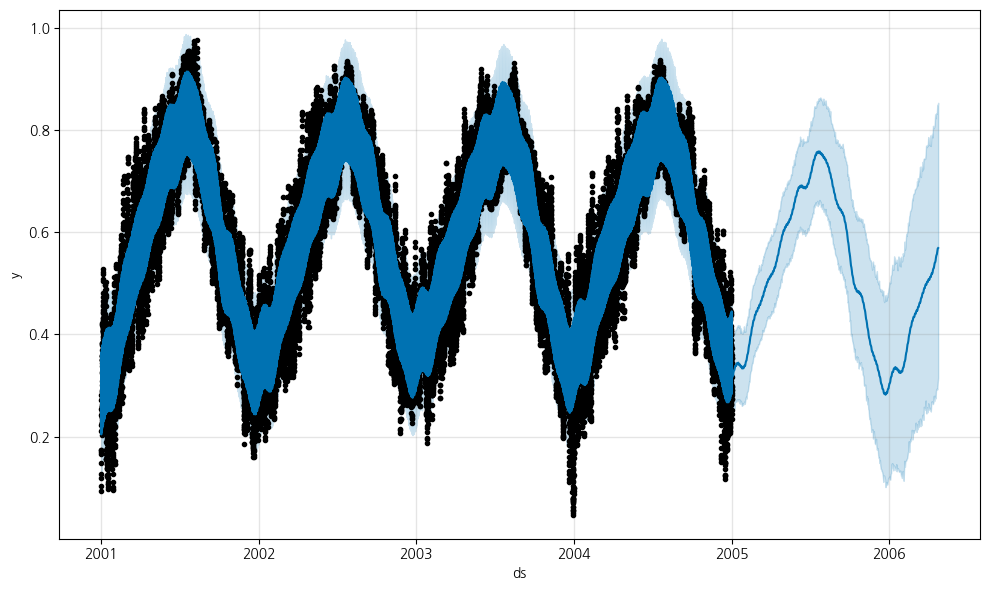

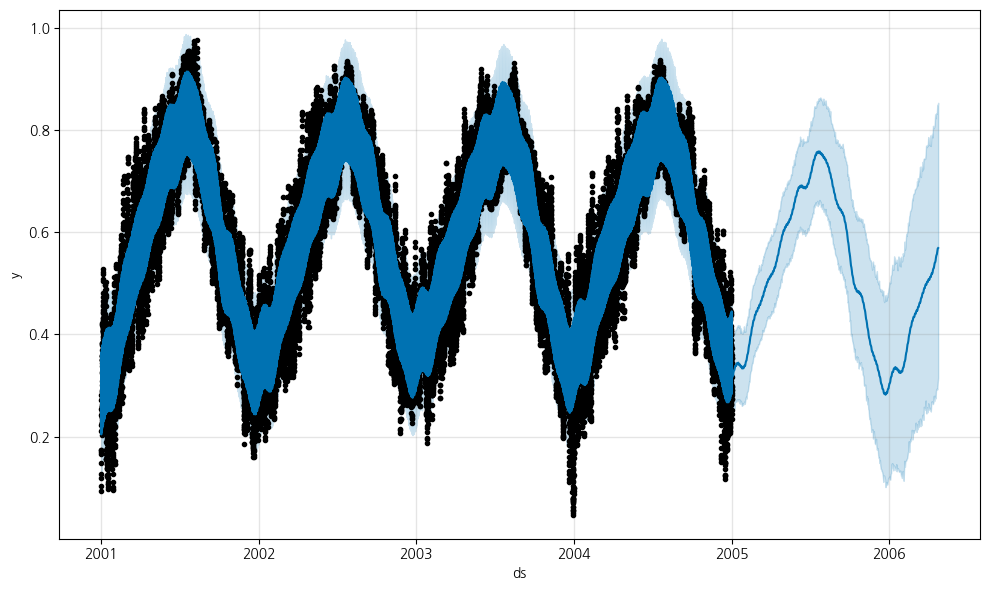

In [36]:
model.plot(forecast)

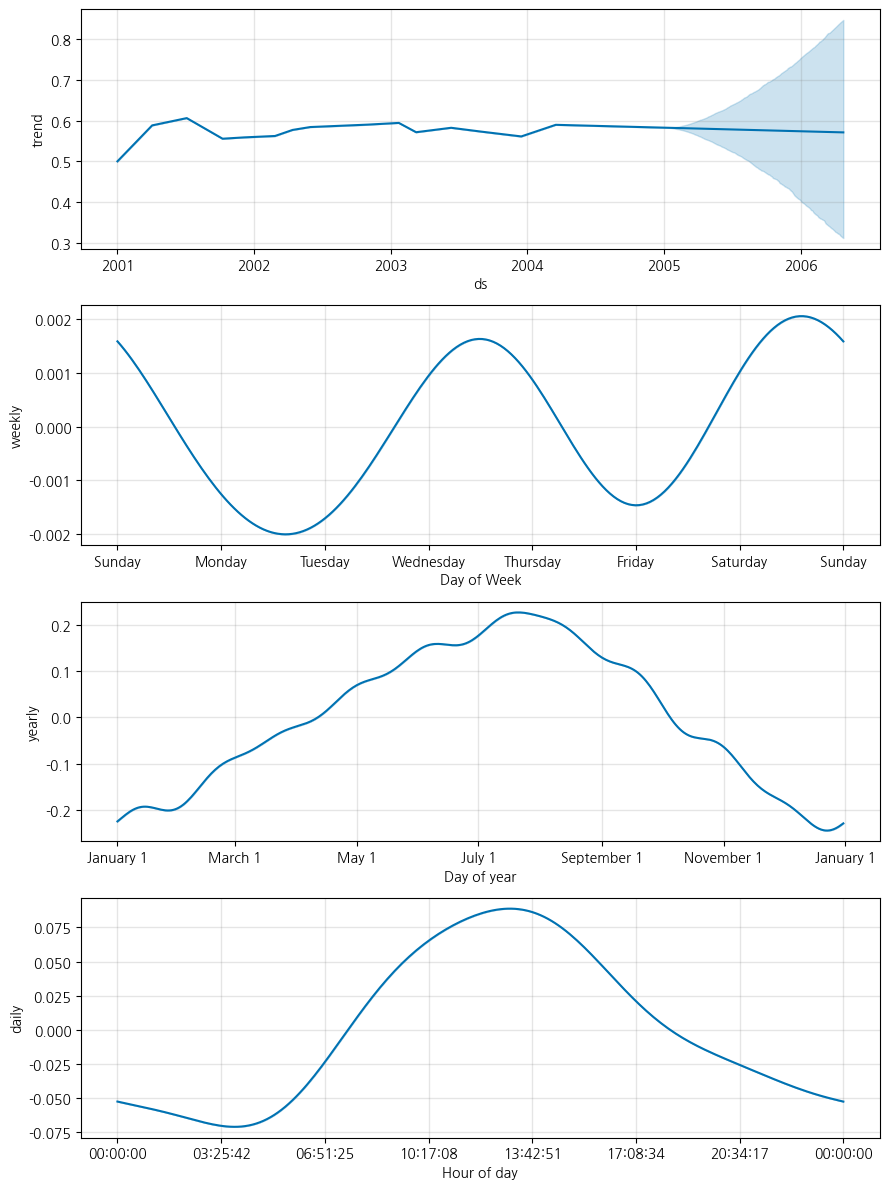

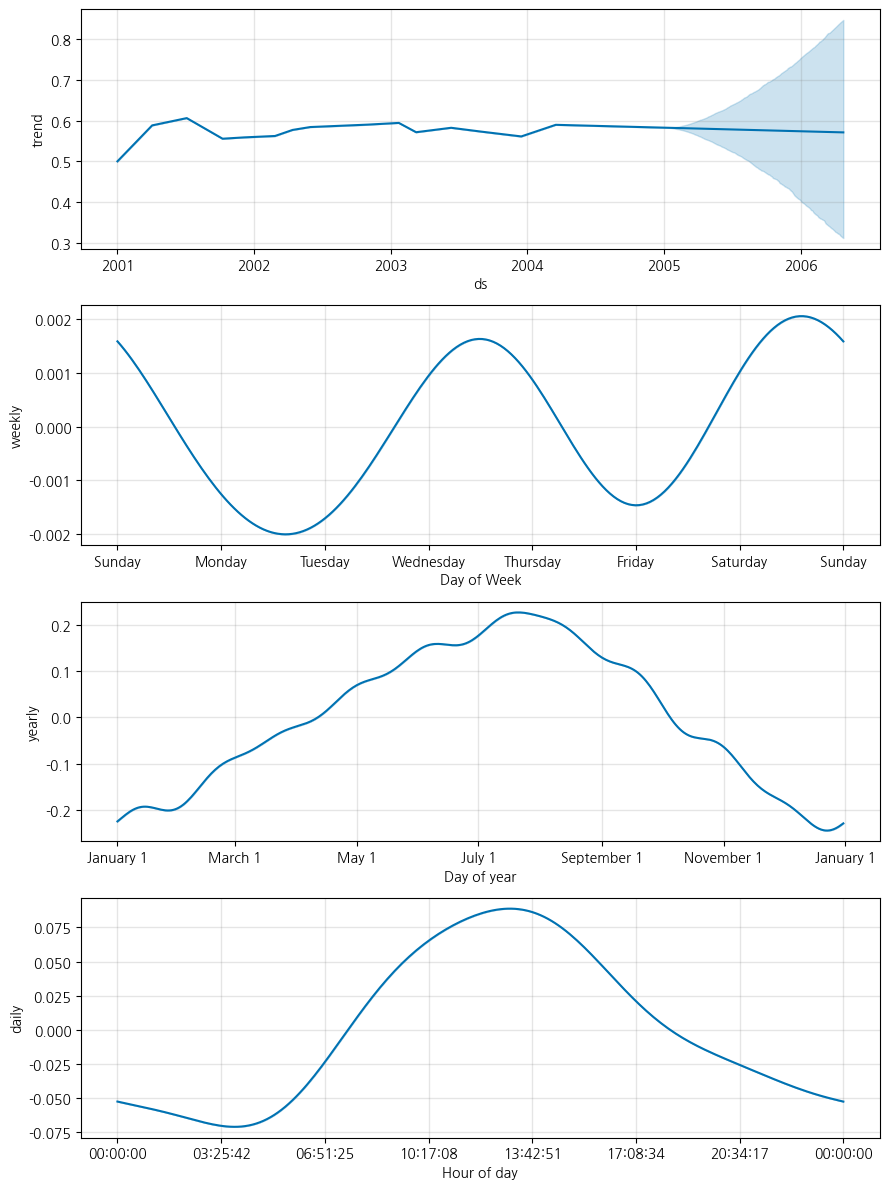

In [41]:
model.plot_components(forecast)

<Axes: xlabel='ds'>

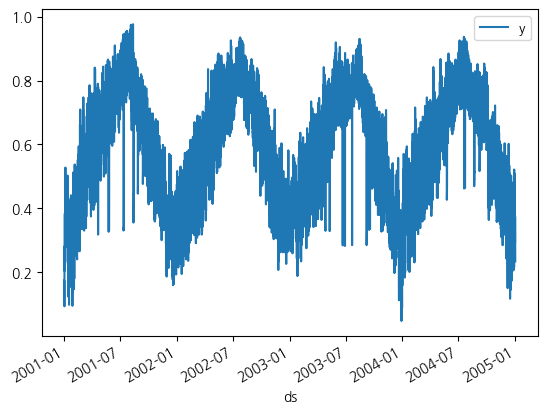

In [38]:
df_filled.plot(x='ds',y='y')

##### 시도2

In [49]:
# Prophet 모델 학습을 위한 데이터프레임 정리
df_prophet = weather[['일시', '기온(°C)']].rename(columns={'일시': 'ds', '기온(°C)': 'y'})

# 2. Prophet 모델 초기화
m = Prophet(seasonality_mode='multiplicative')

# 3. Prophet 모델에 데이터 적합
m.fit(df_prophet)

# 4. 결측치가 있는 시계열 데이터 생성
df_missing = df_prophet[df_prophet['y'].isnull()].copy()
future = model.make_future_dataframe(periods=len(df_missing))

# 5. Prophet 모델을 사용하여 결측치 예측
forecast = m.predict(future)

# 6. 예측 결과에서 결측치가 채워진 부분 추출
df_missing['y'] = forecast['yhat'].tail(len(df_missing)).values
df_filled = pd.concat([df_prophet[~df_prophet['y'].isnull()], df_missing])

# 결과 확인
print(df_filled.head())

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vbt22or/7keit4p4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vbt22or/x2x12rzh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90434', 'data', 'file=/tmp/tmp0vbt22or/7keit4p4.json', 'init=/tmp/tmp0vbt22or/x2x12rzh.json', 'output', 'file=/tmp/tmp0vbt22or/prophet_models_f_ojgl/prophet_model-20230505074418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:44:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                   ds         y
0 2001-01-01 00:00:00  0.173776
1 2001-01-01 01:00:00  0.173776
2 2001-01-01 02:00:00  0.165877
3 2001-01-01 03:00:00  0.148499
4 2001-01-01 04:00:00  0.126382


<Axes: xlabel='ds'>

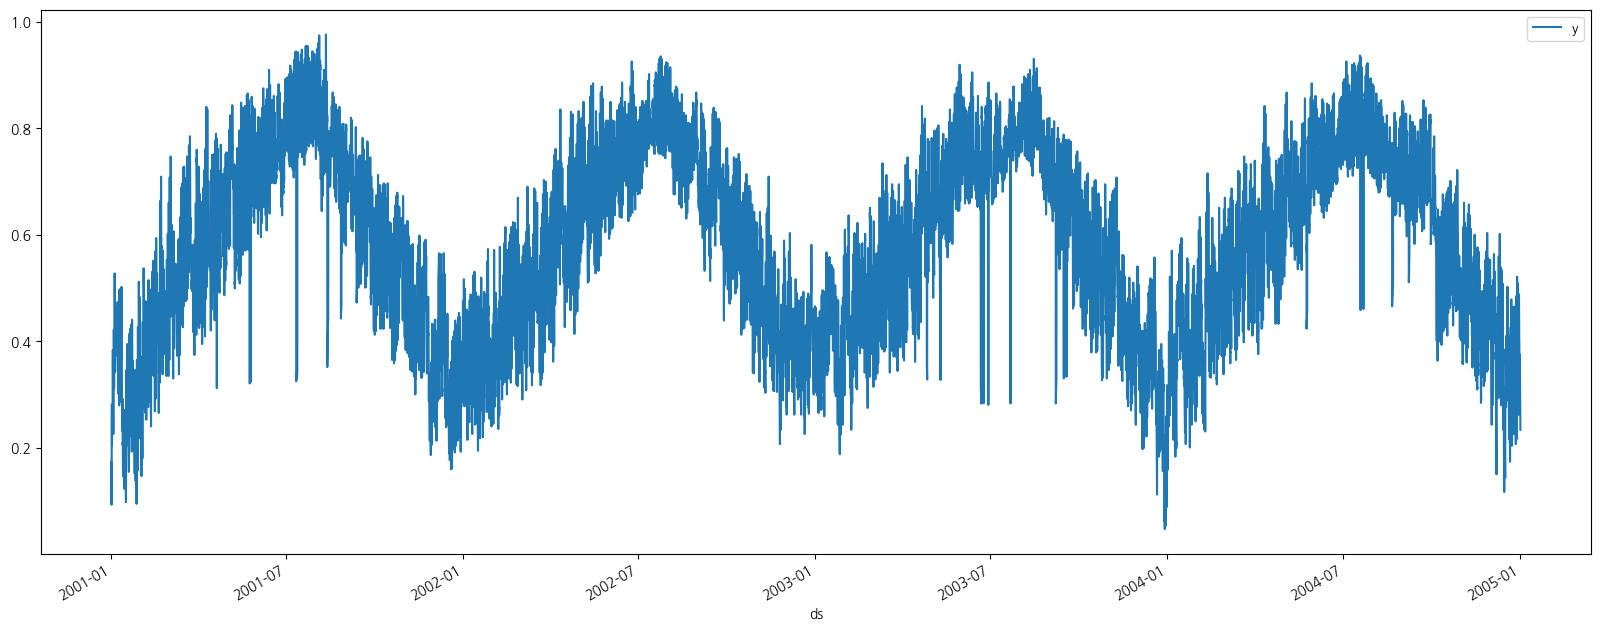

In [54]:
df_filled.plot(x='ds',y='y',figsize=(20,8))

<Axes: xlabel='ds'>

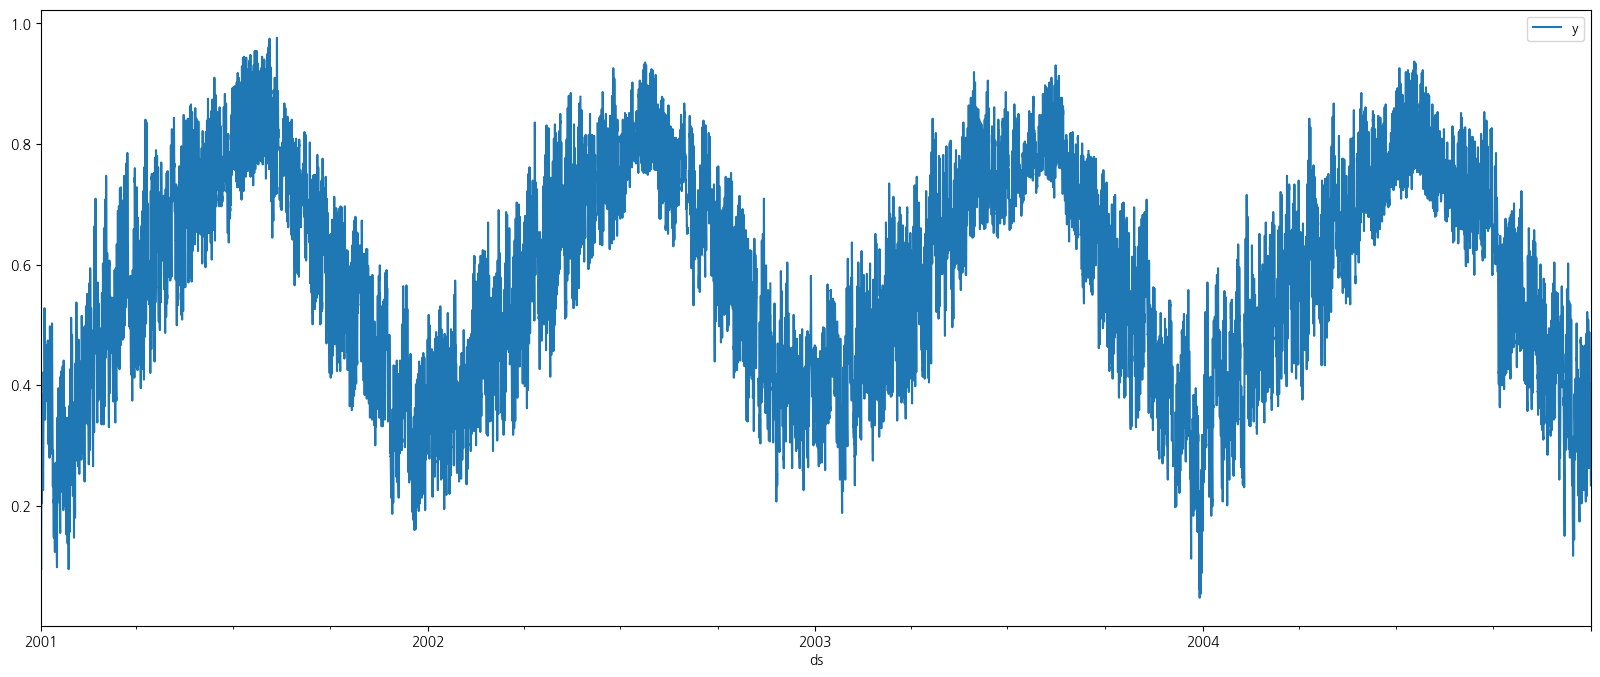

In [53]:
df_prophet.plot(x='ds',y='y',figsize=(20,8))

### - 부록

#### facebook prophat 
 - https://facebook.github.io/prophet/docs/quick_start.html

#### prophet 최신버전 관련 내용
 - https://jayheya.tistory.com/85